<a href="https://colab.research.google.com/github/codeSamuraii/ml-experiments/blob/main/CompressionDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# JPEG Compression detection with Keras
The objective of this notebook is to train a machine learning model to recognise images that have been compressed using a lossy algorithm (such as JPEG) from original high-quality ones.


## Fetching and preparing the dataset files
We'll use a landscape images dataset from Kaggle.

_You'll need a Kaggle account to download the dataset._


In [ ]:
import os
kaggle_ids = input('Content of your ~/.kaggle/kaggle.json: ')
os.environ['KAGGLE_JSON'] = kaggle_ids

!mkdir ~/.kaggle; echo $KAGGLE_JSON > ~/.kaggle/kaggle.json

Download the dataset:

In [32]:
!mkdir /content/dataset; cd /content/dataset && kaggle datasets download -d arnaud58/landscape-pictures -w --unzip

mkdir: cannot create directory ‘/content/dataset’: File exists
100% 619M/620M [00:28<00:00, 23.9MB/s]
100% 620M/620M [00:28<00:00, 22.9MB/s]


Compress the images using Pillow, and put them in separate folders under `training`, one for `compressed` images, one for `quality` images:

In [2]:
!cd /content; rm -rf training; mkdir training; mkdir training/compressed; mkdir training/quality

import os
import pathlib
import tensorflow as tf
from PIL import Image
from itertools import chain


# Images have different extensions
folder = pathlib.Path('dataset')
extensions = {'*.jpg', '*.jpeg'}
images = list(chain.from_iterable(folder.glob(ext) for ext in extensions))
nb_img, nb_errors = len(images), 0
print(f'Found {nb_img} images.')

for i, image_file in enumerate(images):
    try:
      im = Image.open(image_file, formats=['JPEG'])
      im.save(f'training/quality/{i}.jpg', optimize=True, quality='keep')
    except (OSError, ValueError):
      nb_errors += 1
      continue

    im.save(f'training/compressed/{i}.jpg', optimize=False, quality=10)

    if i % 1000 == 0:
        progress = int(i / nb_img * 100)
        print(f'{progress}% ({i}/{nb_img} E={nb_errors})')

print('Done.')

Found 4319 images.
0% (0/4319 E=0)
23% (1000/4319 E=0)
46% (2000/4319 E=0)
69% (3000/4319 E=0)
92% (4000/4319 E=0)
Done.


## Splitting the dataset
Now that we have created our compressed images, let's use Keras to split the dataset between training and validation. Keras will understand that each subdirectory of `training` is a class we're trying to predict.

In [27]:
import tensorflow as tf


batch_size = 16
img_height = 1000
img_width = 1000

train_dataset = tf.keras.utils.image_dataset_from_directory(
  'training',
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  crop_to_aspect_ratio=True,
  # label_mode='binary',
  batch_size=batch_size
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
  'training',
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  crop_to_aspect_ratio=True,
  # label_mode='binary',
  batch_size=batch_size
)

class_names = train_dataset.class_names
num_classes = len(class_names)
print(f'{num_classes} classes: {class_names}')

Found 8638 files belonging to 2 classes.
Using 6911 files for training.
Found 8638 files belonging to 2 classes.
Using 1727 files for validation.
2 classes: ['compressed', 'quality']


> **Note that the dataset has been configured to perform a *categorical* classification.**
>
> It is suited for classifications with two or more classes. The output will be the computed probability for an image to belong to each class. For a compressed image: `[0.97, 0.03]` for example.
>
> Considering we are only trying to predict if an image is compressed or not, we could have used a *binary* classification, which would only output "yes" (`1`) or "no" (`0`). For that we would need to uncomment `label_mode='binary'` and modify the model's output layer.

Check that pictures have been assigned to the correct label:

Pixel values in [0.0:255.0]


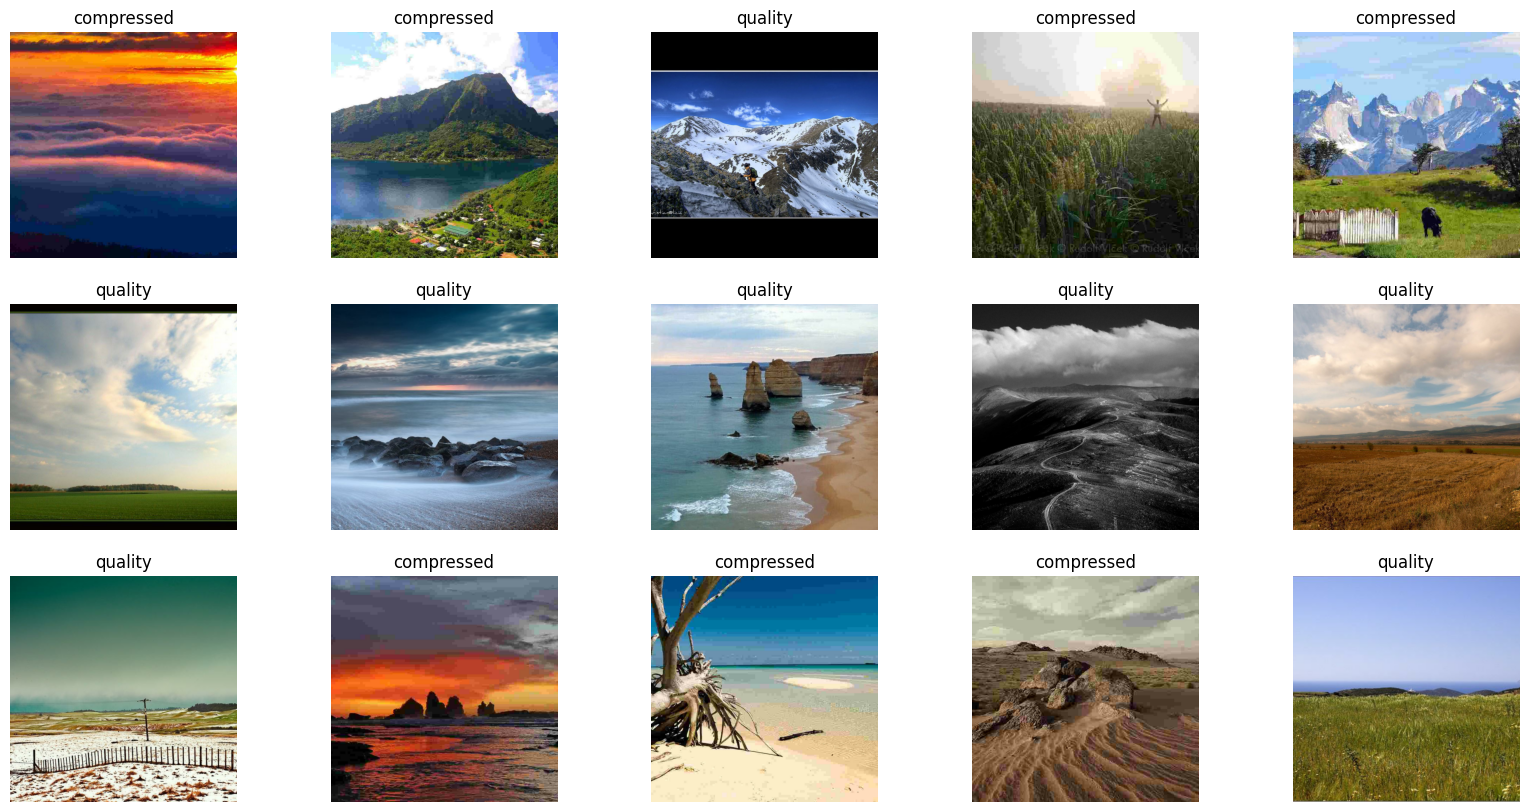

In [28]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
for images, labels in train_dataset.take(1):
  for i in range(15):
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

image_batch, _ = next(iter(train_dataset))
first_image = image_batch[0]
print(f'Pixel values in [{np.min(first_image)}:{np.max(first_image)}]')


We can see that compressed images have artifacts, especially in gradient areas like the sky. Our model should be able to pick up these details.

## Create the model and train
We create a basic CNN network made of convolutions and pooling layers increasing in filter size.

To prevent overfitting, the images go through a preprocessing layers where data augmentation operations are performed like flip and zoom. A dropout layer after the convolutions helps further.

Data is rescaled to the `[0: 100]` range during that process as it is common when using RGB data.

We also put in place checkpoint and early stopping callbacks that will stop the training prematurely if performance drops and restore the best weights.

> For a *binary* classification, we simply need to change the output layer's dimension to `1` and use a *binary crossentropy* loss function.

In [30]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


preprocess = keras.Sequential([
    # Augmentation
    layers.RandomFlip(input_shape=(img_height, img_width, 3)),
    layers.RandomZoom((0.0, 0.2)),

    # Rescaling
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
])


model = Sequential([
  preprocess,

  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Dropout(0.2),

  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
  # layers.Dense(1, activation='sigmoid')
])


model.compile(optimizer='Adamax',
              loss='sparse_categorical_crossentropy',
              # loss='binary_crossentropy',
              metrics=['accuracy'])

checkpoint = tf.keras.callbacks.ModelCheckpoint('jpeg_detect_q10.h5', save_best_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(start_from_epoch=5, patience=5, restore_best_weights=True)

history = model.fit(train_dataset, epochs=30, validation_data=validation_dataset, callbacks=[checkpoint, early_stop])

loss, accuracy = model.evaluate(validation_dataset)
print("Loss: ", loss)
print("Accuracy: ", accuracy)



Epoch 1/30
432/432 [==============================] - 63s 141ms/step - loss: 1.0599 - accuracy: 0.5021 - val_loss: 0.6929 - val_accuracy: 0.5072
Epoch 2/30
432/432 [==============================] - 64s 147ms/step - loss: 0.6922 - accuracy: 0.5161 - val_loss: 0.6905 - val_accuracy: 0.5281
Epoch 3/30
432/432 [==============================] - 58s 134ms/step - loss: 0.6897 - accuracy: 0.5273 - val_loss: 0.6904 - val_accuracy: 0.5327
Epoch 4/30
432/432 [==============================] - 58s 133ms/step - loss: 0.6835 - accuracy: 0.5610 - val_loss: 0.6803 - val_accuracy: 0.5541
Epoch 5/30
432/432 [==============================] - 58s 133ms/step - loss: 0.6767 - accuracy: 0.5810 - val_loss: 0.6466 - val_accuracy: 0.6109
Epoch 6/30
432/432 [==============================] - 59s 135ms/step - loss: 0.6530 - accuracy: 0.6267 - val_loss: 0.6466 - val_accuracy: 0.6248
Epoch 7/30
432/432 [==============================] - 58s 134ms/step - loss: 0.6302 - accuracy: 0.6459 - val_loss: 0.5955 - val_ac

We can see the model wasn't improving after epoch 17, weights have therefore been restored to that training step.

## Review performance

Let's plot the training statistics :

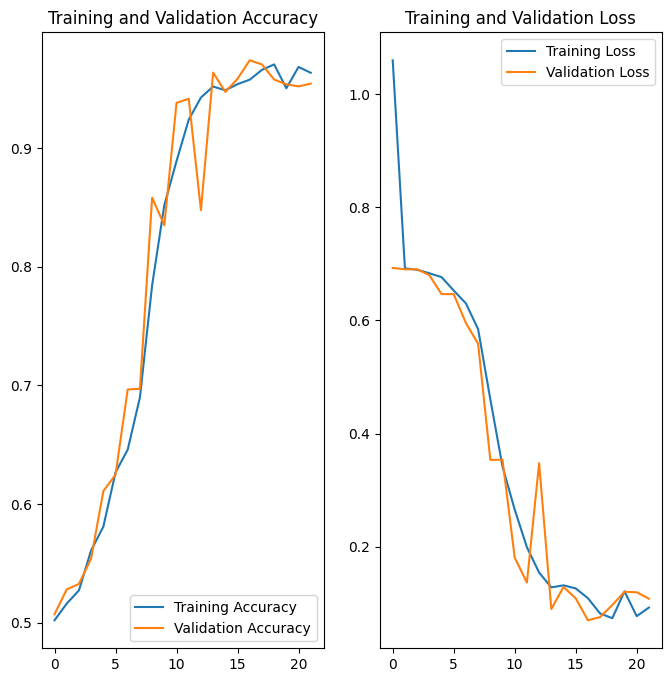

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
nb_epochs = len(history.history['val_loss'])
epochs_range = range(nb_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


We can see that there was no overfitting and validation loss nicely follows training.

## Save the model
Let's save our model, we can use it for predictions straight away or for reinforcement learning.

In [37]:
import tempfile
import zipfile

print("Saving model...")
_, model_file = tempfile.mkstemp('.h5', dir='/content/')
tf.keras.models.save_model(model, model_file, include_optimizer=False)
print("Saved to: ", model_file)

print("Zipping...")
_, zipped_model_file = tempfile.mkstemp('.zip', dir='/content/')
with zipfile.ZipFile(zipped_model_file, "w", compression=zipfile.ZIP_DEFLATED) as f:
    f.write(model_file)
print("Compressed model saved to: ", zipped_model_file)

Saving model...
Saved to:  /content/tmpmgn76ixb.h5
Zipping...
Compressed model saved to:  /content/tmp_aj3c_l_.zip


## Make some predictions
Let's try some random predictions :

In [52]:
import numpy as np
from random import randint, choice

# 100 random predictions
for i in range(100):
  rand_class = choice(class_names)
  rand_file = f'training/{rand_class}/{randint(0,1000)}.jpg'
  img = tf.keras.utils.load_img(
      rand_file, target_size=(img_height, img_width)
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array, verbose=False)
  score = tf.nn.softmax(predictions[0])

  pred_class, pred_confidence = class_names[np.argmax(score)], 100 * np.max(score)
  if pred_class != rand_class:
    print(f'FAIL - input: {rand_class} > pred: {pred_class} ({pred_confidence:.2f}) - {rand_file}')


FAIL - input: quality > pred: compressed (52.52) - training/quality/456.jpg
FAIL - input: compressed > pred: quality (55.91) - training/compressed/247.jpg


We can see that our model performs decently. When it fails to predict the right answer, the confidence score is low (~55%). In a real application, we could filter results with a minimum score.